# Vessel_seg quickstart

This notebook explains the minimal end-to-end pipeline added in the refactor and shows a toy run on synthetic data (no external files needed).

In [ ]:
# Ensure dependency for skeletonization
try:
    import skimage  # noqa: F401
    from skimage import __version__ as skv
    print("Using scikit-image", skv)
except ImportError:
    raise RuntimeError("Please install scikit-image (pip install scikit-image) before running this notebook.")


Using scikit-image 0.25.2


## What was added
- Core data models (`Branch`, `CoronaryTree`) with JSON IO and helpers.
- Skeleton-based centerline extraction (`extract_centerlines_from_mask`).
- Light IO/preprocessing utils (`load_nifti`, `resample_isotropic`, `crop_to_mask`).
- Simple visualization (`show_slice_with_mask`, 3D centerline plotting).
- Placeholder statistical models (`SimpleLengthRadiusModel`, `CoronaryTreePrior`).
- Runnable experiment scripts under `vessel_seg/experiments/`.

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

root_guess = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().resolve()
if root_guess.name == "notebooks":
    root_guess = root_guess.parent
ROOT = root_guess
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from vessel_seg.centerline import extract_centerlines_from_mask
from vessel_seg.graph_structure import CoronaryTree
from vessel_seg.visualization import show_slice_with_mask, plot_centerlines_3d
from vessel_seg.branch_model import SimpleLengthRadiusModel

## Create a toy coronary mask (synthetic)
We build a simple tubular volume: two branches with a bifurcation.

Mask voxels: 1375


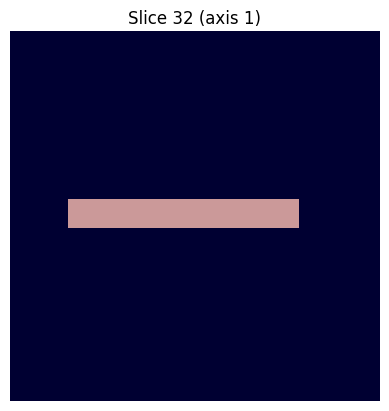

In [3]:
shape = (64, 64, 64)
mask = np.zeros(shape, dtype=np.uint8)

# Main tube along x
for x in range(10, 50):
    mask[x, 32-2:32+3, 32-2:32+3] = 1

# Side branch going up in y
for y in range(32, 50):
    mask[40-2:40+3, y, 32-2:32+3] = 1

spacing = (0.8, 0.8, 0.8)  # mm
print("Mask voxels:", mask.sum())
_ = show_slice_with_mask(mask, mask, axis=1, index=32)
plt.show()

## Extract centerlines and basic stats

In [4]:
tree: CoronaryTree = extract_centerlines_from_mask(mask, spacing)
print("Branches:", tree.num_branches())
print("Total length (mm):", round(tree.total_length(), 2))
for br in tree.iter_branches():
    print(f"Branch {br.id}: points={br.num_points()}, length={br.length():.2f} mm, children={br.child_ids}")

Branches: 931
Total length (mm): 909.06
Branch 0: points=2, length=1.13 mm, children=[1, 2, 3, 4, 5, 6, 7, 233, 518, 663, 664]
Branch 1: points=2, length=0.80 mm, children=[0, 2, 3, 4, 5, 6, 7, 230, 231, 232, 233, 234, 235, 236]
Branch 2: points=2, length=1.13 mm, children=[0, 1, 3, 4, 5, 6, 7, 68, 154, 234, 331, 590, 732, 733]
Branch 3: points=2, length=0.80 mm, children=[0, 1, 2, 4, 5, 6, 7, 235, 518, 519, 520]
Branch 4: points=2, length=0.80 mm, children=[0, 1, 2, 3, 5, 6, 7, 157, 236, 333, 590, 591, 592, 593]
Branch 5: points=2, length=1.13 mm, children=[0, 1, 2, 3, 4, 6, 7, 519, 621, 651, 873]
Branch 6: points=2, length=0.80 mm, children=[0, 1, 2, 3, 4, 5, 7, 520, 591, 622, 651, 652, 653, 654]
Branch 7: points=2, length=1.13 mm, children=[0, 1, 2, 3, 4, 5, 6, 159, 592, 623, 652, 704, 728, 906]
Branch 8: points=2, length=0.80 mm, children=[9, 10, 11, 12, 36, 37, 38, 39]
Branch 9: points=2, length=1.13 mm, children=[8, 10, 11, 12, 38, 162, 198, 594, 635, 636, 637]
Branch 10: points=

## Fit trivial length/radius model and sample

In [5]:
model = SimpleLengthRadiusModel()
model.fit(list(tree.iter_branches()))
sampled = model.sample(num_points=16)
print("Fitted stats:", model.stats)
print("Sampled branch length (mm):", sampled.length())

Fitted stats: LengthRadiusStats(length_mean=0.9764321287003547, length_std=0.18466836207383025, radius_mean=1.5394200144853807, radius_std=0.5707186037941773)
Sampled branch length (mm): 1.3359531164169312


## Visualize centerlines (3D)
For quick QA; uses matplotlib 3D.

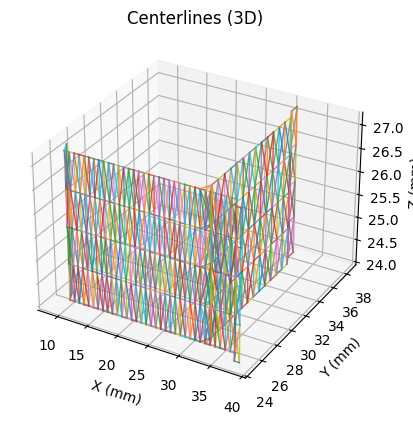

In [6]:
_ = plot_centerlines_3d(tree)
plt.show()